Score Switching

In [2]:
# =============================================================================
# 1. IMPORTS AND CONFIGURATION
# =============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from transformers import AutoModel
from timm import create_model
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from tqdm import tqdm
import os
from collections import OrderedDict

# --- Main Configuration ---
config = {
    'base_dir': r'A:\Speech Journal\melspectrograms_dataset',
    'batch_size': 16,
    'img_size': 224,
    'num_workers': 0,

    # --- Model Names (CORRECTED) ---
    'dino_model_name': 'facebook/dinov3-convnext-tiny-pretrain-lvd1689m', # Correct Hugging Face ID
    'eva_model_name': 'eva02_tiny_patch14_224.mim_in22k',
    'maxvit_model_name': 'maxvit_tiny_tf_224.in1k',

    # --- Model Paths (TODO: UPDATE THESE) ---
    'dino_model_path': r'A:\Speech Journal\v3 dinov3\best_finetuned_model.pth',
    'eva_model_path': r'A:\Speech Journal\V5 Eva02\best_finetuned_model.pth',
    'maxvit_model_path': r'A:\Speech Journal\v6 maxVit\best_full_model.pth',
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# =============================================================================
# 2. MODEL AND HELPER DEFINITIONS
# =============================================================================

# Wrapper for the Hugging Face DinoV3 model
class TransformersClassifier(nn.Module):
    def __init__(self, model_name, num_classes, drop_rate=0.0):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        feature_dim = self.backbone.config.hidden_sizes[-1]
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512), nn.BatchNorm1d(512), nn.GELU(),
            nn.Dropout(drop_rate), nn.Linear(512, num_classes)
        )
    def forward(self, x):
        outputs = self.backbone(pixel_values=x)
        features = torch.mean(outputs.last_hidden_state, dim=1)
        return self.classifier(features)

# Wrapper for the timm MaxViT model
class TimmClassifier(nn.Module):
    def __init__(self, model_name, num_classes, drop_rate=0.0):
        super().__init__()
        self.backbone = create_model(model_name, pretrained=False, num_classes=0)
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512), nn.BatchNorm1d(512), nn.GELU(),
            nn.Dropout(drop_rate), nn.Linear(512, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.backbone(x))

def get_data_loaders(base_dir, img_size, batch_size, num_workers):
    data_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    val_dataset = datasets.ImageFolder(root=os.path.join(base_dir, 'validation'), transform=data_transform)
    test_dataset = datasets.ImageFolder(root=os.path.join(base_dir, 'test'), transform=data_transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    print(f"Found {len(val_dataset)} validation and {len(test_dataset)} test images.")
    return val_loader, test_loader, test_dataset.classes

def load_model_weights(model, path, device):
    """Robustly loads weights from a checkpoint dict or a direct state_dict."""
    checkpoint = torch.load(path, map_location=device)
    state_dict = checkpoint.get('model_state_dict', checkpoint)
    model.load_state_dict(state_dict)
    print(f"✅ Loaded weights for {model.__class__.__name__} from: {os.path.basename(path)}")

# =============================================================================
# 3. ADVANCED ENSEMBLE FUNCTIONS
# =============================================================================

# All your advanced functions (Temperature Scaling, Stacking, Disagreement, etc.)
# are included here to be defined before they are called.

class ModelWithTemperature(nn.Module):
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)
    def forward(self, input):
        return self.temperature_scale(self.model(input))
    def temperature_scale(self, logits):
        return logits / self.temperature

def find_optimal_temperature(model, val_loader, device):
    model.eval()
    scaled_model = ModelWithTemperature(model).to(device)
    nll_criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.LBFGS([scaled_model.temperature], lr=0.01, max_iter=50)
    def eval_closure():
        optimizer.zero_grad()
        with torch.no_grad():
            all_logits, all_labels = [], []
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                all_logits.append(model(inputs))
                all_labels.append(labels)
            all_logits, all_labels = torch.cat(all_logits), torch.cat(all_labels)
        scaled_logits = scaled_model.temperature_scale(all_logits)
        loss = nll_criterion(scaled_logits, all_labels)
        loss.backward()
        return loss
    optimizer.step(eval_closure)
    return scaled_model.temperature.item()

def extract_meta_features(models, temperatures, data_loader, device):
    all_features, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Extracting meta-features"):
            images = images.to(device)
            batch_features = []
            for model, temp in zip(models, temperatures):
                probs = F.softmax(model(images) / temp, dim=1)
                batch_features.append(probs.cpu().numpy())
            batch_features = np.concatenate(batch_features, axis=1)
            all_features.append(batch_features)
            all_labels.extend(labels.numpy())
    return np.vstack(all_features), np.array(all_labels)

def stacking_ensemble(models, temperatures, val_loader, test_loader, class_names, meta_model='rf'):
    print(f"\n{'='*60}\nSTACKING ENSEMBLE ({meta_model.upper()})\n{'='*60}")
    X_val, y_val = extract_meta_features(models, temperatures, val_loader, device)
    if meta_model == 'rf':
        meta_learner = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
    else:
        meta_learner = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
    meta_learner.fit(X_val, y_val)
    val_acc = accuracy_score(y_val, meta_learner.predict(X_val))
    print(f"Meta-learner validation accuracy: {val_acc:.2%}")
    X_test, y_test = extract_meta_features(models, temperatures, test_loader, device)
    return y_test, meta_learner.predict(X_test)

def disagreement_focused_ensemble(models, temperatures, val_loader, test_loader, class_names):
    # ... (Your function code for disagreement_focused_ensemble)
    return [], [] # Placeholder to avoid error

def confidence_margin_switching(models, temperatures, test_loader, class_names):
    # ... (Your function code for confidence_margin_switching)
    return [], [] # Placeholder to avoid error

def boosted_weighted_voting(models, temperatures, val_loader, test_loader, class_names):
    # ... (Your function code for boosted_weighted_voting)
    return [], [] # Placeholder to avoid error
    
def evaluate_predictions(labels, preds, class_names, method_name):
    print(f"\n{'='*60}\n{method_name}\n{'='*60}")
    accuracy = accuracy_score(labels, preds)
    print(f"Overall Accuracy: {accuracy:.4f} ({accuracy:.2%})")
    laryngitis_idx = class_names.index('Laryngitis')
    true_arr, pred_arr = np.array(labels), np.array(preds)
    laryngitis_mask = true_arr == laryngitis_idx
    laryngitis_acc = accuracy_score(true_arr[laryngitis_mask], pred_arr[laryngitis_mask]) if laryngitis_mask.any() else 0
    print(f"Laryngitis Accuracy: {laryngitis_acc:.2%}")
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=class_names, digits=4))
    return accuracy

# =============================================================================
# 4. MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    val_loader, test_loader, class_names = get_data_loaders(
        config['base_dir'], config['img_size'], config['batch_size'], config['num_workers']
    )
    num_classes = len(class_names)

    print("\n--- Loading Models With Correct Architectures ---")
    model_dino = TransformersClassifier(config['dino_model_name'], num_classes).to(device)
    load_model_weights(model_dino, config['dino_model_path'], device)

    model_eva = create_model(config['eva_model_name'], pretrained=False, num_classes=num_classes).to(device)
    load_model_weights(model_eva, config['eva_model_path'], device)

    model_maxvit = TimmClassifier(config['maxvit_model_name'], num_classes).to(device)
    load_model_weights(model_maxvit, config['maxvit_model_path'], device)

    models = [model_dino, model_eva, model_maxvit]

    print("\n--- Calibrating Models ---")
    optimal_temperatures = [find_optimal_temperature(model, val_loader, device) for model in models]
    print(f"Final Optimal Temperatures (Dino, EVA, MaxViT): {[f'{t:.3f}' for t in optimal_temperatures]}")
    
    results = {}
    
    # --- Run and Evaluate All Ensemble Methods ---
    # NOTE: I've used placeholders for your other methods to make this runnable. 
    # You should paste your full function definitions back in.
    
    labels1, preds1 = stacking_ensemble(models, optimal_temperatures, val_loader, test_loader, class_names, meta_model='rf')
    results['Stacking-RF'] = evaluate_predictions(labels1, preds1, class_names, "STACKING (Random Forest)")
    
    labels2, preds2 = stacking_ensemble(models, optimal_temperatures, val_loader, test_loader, class_names, meta_model='lr')
    results['Stacking-LR'] = evaluate_predictions(labels2, preds2, class_names, "STACKING (Logistic Regression)")
    
    # labels3, preds3 = disagreement_focused_ensemble(models, optimal_temperatures, val_loader, test_loader, class_names)
    # results['Disagreement-Focused'] = evaluate_predictions(labels3, preds3, class_names, "DISAGREEMENT-FOCUSED")
    
    # labels4, preds4 = confidence_margin_switching(models, optimal_temperatures, test_loader, class_names)
    # results['Confidence-Margin'] = evaluate_predictions(labels4, preds4, class_names, "CONFIDENCE-MARGIN")
    
    # labels5, preds5 = boosted_weighted_voting(models, optimal_temperatures, val_loader, test_loader, class_names)
    # results['Boosted-Weighted'] = evaluate_predictions(labels5, preds5, class_names, "BOOSTED WEIGHTED VOTING")
    
    print("\n" + "="*60 + "\nFINAL SUMMARY\n" + "="*60)
    for method, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
        print(f"{method:25s}: {acc:.2%}")

Using device: cuda
Found 73 validation and 74 test images.

--- Loading Models With Correct Architectures ---
✅ Loaded weights for TransformersClassifier from: best_finetuned_model.pth
✅ Loaded weights for Eva from: best_finetuned_model.pth
✅ Loaded weights for TimmClassifier from: best_full_model.pth

--- Calibrating Models ---
Final Optimal Temperatures (Dino, EVA, MaxViT): ['1.304', '1.328', '1.091']

STACKING ENSEMBLE (RF)


Extracting meta-features: 100%|██████████| 5/5 [00:01<00:00,  4.43it/s]


Meta-learner validation accuracy: 100.00%


Extracting meta-features: 100%|██████████| 5/5 [00:01<00:00,  4.22it/s]



STACKING (Random Forest)
Overall Accuracy: 0.8378 (83.78%)
Laryngitis Accuracy: 69.23%

Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.6000    0.6923    0.6429        13
           Laryngozele     0.8000    0.8889    0.8421         9
           Vox senilis     0.9167    0.8462    0.8800        13
             parkinson     1.0000    1.0000    1.0000        13
spasmodische_dysphonie     0.7273    0.6154    0.6667        13

              accuracy                         0.8378        74
             macro avg     0.8407    0.8405    0.8386        74
          weighted avg     0.8429    0.8378    0.8384        74


STACKING ENSEMBLE (LR)


Extracting meta-features: 100%|██████████| 5/5 [00:01<00:00,  4.36it/s]
c:\Users\sreeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Meta-learner validation accuracy: 91.78%


Extracting meta-features: 100%|██████████| 5/5 [00:01<00:00,  4.31it/s]


STACKING (Logistic Regression)
Overall Accuracy: 0.8378 (83.78%)
Laryngitis Accuracy: 69.23%

Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.6000    0.6923    0.6429        13
           Laryngozele     0.7273    0.8889    0.8000         9
           Vox senilis     0.9167    0.8462    0.8800        13
             parkinson     1.0000    1.0000    1.0000        13
spasmodische_dysphonie     0.8000    0.6154    0.6957        13

              accuracy                         0.8378        74
             macro avg     0.8407    0.8405    0.8364        74
          weighted avg     0.8468    0.8378    0.8384        74


FINAL SUMMARY
Stacking-RF              : 83.78%
Stacking-LR              : 83.78%


In [ ]:
# =============================================================================
# 1. IMPORTS AND CONFIGURATION
# =============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import AutoModel
from timm import create_model
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from tqdm import tqdm
import os
from collections import OrderedDict

# --- Main Configuration ---
config = {
    'base_dir': r'A:\Speech Journal\melspectrograms_dataset',
    'batch_size': 16,
    'img_size': 224,
    'num_workers': 0,

    # --- Model Names (Corrected) ---
    'dino_model_name': 'facebook/dinov3-convnext-tiny-pretrain-lvd1689m', # Correct Hugging Face ID
    'eva_model_name': 'eva02_tiny_patch14_224.mim_in22k',
    'maxvit_model_name': 'maxvit_tiny_tf_224.in1k',

    # --- Model Paths (TODO: UPDATE THESE) ---
    'dino_model_path': r'A:\Speech Journal\v3 dinov3\best_finetuned_model.pth',
    'eva_model_path': r'A:\Speech Journal\V5 Eva02\best_finetuned_model.pth',
    'maxvit_model_path': r'A:\Speech Journal\v6 maxVit\best_full_model.pth',
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# =============================================================================
# 2. MODEL WRAPPER AND HELPER DEFINITIONS
# =============================================================================

# Wrapper for the Hugging Face DinoV3 model
class TransformersClassifier(nn.Module):
    def __init__(self, model_name, num_classes, drop_rate=0.0):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        feature_dim = self.backbone.config.hidden_sizes[-1]
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512), nn.BatchNorm1d(512), nn.GELU(),
            nn.Dropout(drop_rate), nn.Linear(512, num_classes)
        )
    def forward(self, x):
        outputs = self.backbone(pixel_values=x)
        features = torch.mean(outputs.last_hidden_state, dim=1)
        return self.classifier(features)

# Wrapper for the timm MaxViT model
class TimmClassifier(nn.Module):
    def __init__(self, model_name, num_classes, drop_rate=0.0):
        super().__init__()
        self.backbone = create_model(model_name, pretrained=False, num_classes=0)
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512), nn.BatchNorm1d(512), nn.GELU(),
            nn.Dropout(drop_rate), nn.Linear(512, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.backbone(x))

def get_data_loaders(base_dir, img_size, batch_size, num_workers):
    data_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    val_dataset = datasets.ImageFolder(root=os.path.join(base_dir, 'validation'), transform=data_transform)
    test_dataset = datasets.ImageFolder(root=os.path.join(base_dir, 'test'), transform=data_transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    print(f"Found {len(val_dataset)} validation and {len(test_dataset)} test images.")
    return val_loader, test_loader, test_dataset.classes

def load_model_weights(model, path, device):
    """Robustly loads weights from a checkpoint dict or a direct state_dict."""
    checkpoint = torch.load(path, map_location=device)
    state_dict = checkpoint.get('model_state_dict', checkpoint)
    model.load_state_dict(state_dict)
    print(f"✅ Loaded weights for {model.__class__.__name__} from: {os.path.basename(path)}")

# =============================================================================
# 3. ADVANCED ENSEMBLE AND EVALUATION FUNCTIONS
# =============================================================================

class ModelWithTemperature(nn.Module):
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)
    def forward(self, input):
        return self.temperature_scale(self.model(input))
    def temperature_scale(self, logits):
        return logits / self.temperature

def find_optimal_temperature(model, val_loader, device):
    model.eval()
    scaled_model = ModelWithTemperature(model).to(device)
    nll_criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.LBFGS([scaled_model.temperature], lr=0.01, max_iter=50)
    def eval_closure():
        optimizer.zero_grad()
        with torch.no_grad():
            all_logits, all_labels = [], []
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                all_logits.append(model(inputs))
                all_labels.append(labels)
            all_logits, all_labels = torch.cat(all_logits), torch.cat(all_labels)
        scaled_logits = scaled_model.temperature_scale(all_logits)
        loss = nll_criterion(scaled_logits, all_labels)
        loss.backward()
        return loss
    optimizer.step(eval_closure)
    return scaled_model.temperature.item()

def extract_meta_features(models, temperatures, data_loader, device):
    all_features, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Extracting meta-features"):
            images = images.to(device)
            batch_features = []
            for model, temp in zip(models, temperatures):
                probs = F.softmax(model(images) / temp, dim=1)
                batch_features.append(probs.cpu().numpy())
            batch_features = np.concatenate(batch_features, axis=1)
            all_features.append(batch_features)
            all_labels.extend(labels.numpy())
    return np.vstack(all_features), np.array(all_labels)

def stacking_ensemble(models, temperatures, val_loader, test_loader, class_names, meta_model='rf'):
    print(f"\n{'='*60}\nSTACKING ENSEMBLE ({meta_model.upper()})\n{'='*60}")
    X_val, y_val = extract_meta_features(models, temperatures, val_loader, device)
    if meta_model == 'rf':
        meta_learner = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
    else:
        meta_learner = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
    meta_learner.fit(X_val, y_val)
    val_acc = accuracy_score(y_val, meta_learner.predict(X_val))
    print(f"Meta-learner validation accuracy: {val_acc:.2%}")
    X_test, y_test = extract_meta_features(models, temperatures, test_loader, device)
    return y_test, meta_learner.predict(X_test)

def disagreement_focused_ensemble(models, temperatures, val_loader, test_loader, class_names):
    """When models disagree, use a learned 'tie-breaker' expert."""
    print("\n" + "="*60 + "\nDISAGREEMENT-FOCUSED ENSEMBLE\n" + "="*60)
    
    # Learn which model is best when there's disagreement using the validation set
    print("Analyzing disagreement patterns on validation set...")
    disagreement_correct = {i: 0 for i in range(len(models))}
    disagreement_total = {i: 0 for i in range(len(models))}
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Get predictions from all models
            all_preds = []
            for model, temp in zip(models, temperatures):
                preds = (model(images) / temp).argmax(dim=1)
                all_preds.append(preds)
            
            all_preds = torch.stack(all_preds)  # Shape: [num_models, batch_size]
            
            for i in range(images.size(0)):
                sample_preds = all_preds[:, i]
                # Check if there is any disagreement for this sample
                if len(torch.unique(sample_preds)) > 1:
                    true_label = labels[i]
                    for model_idx in range(len(models)):
                        disagreement_total[model_idx] += 1
                        if sample_preds[model_idx] == true_label:
                            disagreement_correct[model_idx] += 1
    
    # Determine the best model to use as a tie-breaker
    disagreement_acc = {i: (disagreement_correct[i] / disagreement_total[i]) if disagreement_total[i] > 0 else 0 for i in range(len(models))}
    
    print("Model performance on disagreement cases:")
    model_names = ['DinoV3', 'EVA-02', 'MaxViT']
    for i, name in enumerate(model_names):
        print(f"  {name}: {disagreement_acc[i]:.2%} ({disagreement_correct[i]}/{disagreement_total[i]})")
    
    best_disagreement_model_idx = max(disagreement_acc, key=disagreement_acc.get)
    print(f"\nBest model for disagreements: {model_names[best_disagreement_model_idx]}")
    
    # Apply the learned strategy to the test set
    all_labels, final_preds = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Disagreement Ensemble"):
            images = images.to(device)
            
            all_model_preds = torch.stack([(model(images) / temp).argmax(dim=1) for model, temp in zip(models, temperatures)])
            
            for i in range(images.size(0)):
                sample_preds = all_model_preds[:, i]
                if len(torch.unique(sample_preds)) == 1:
                    # All models agree, use the consensus prediction
                    final_pred = sample_preds[0].item()
                else:
                    # Models disagree, use the designated tie-breaker expert
                    final_pred = sample_preds[best_disagreement_model_idx].item()
                
                final_preds.append(final_pred)
                all_labels.append(labels[i].item())
                
    return all_labels, final_preds

def confidence_margin_switching(models, temperatures, test_loader, class_names):
    """For each sample, select the prediction from the model with the highest confidence margin."""
    print("\n" + "="*60 + "\nCONFIDENCE-MARGIN SWITCHING\n" + "="*60)
    
    all_labels, final_preds = [], []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Margin Switching"):
            images = images.to(device)
            
            # Get probabilities from all models
            all_probs = torch.stack([F.softmax(model(images) / temp, dim=1) for model, temp in zip(models, temperatures)])
            
            for i in range(images.size(0)):
                margins = []
                for model_idx in range(len(models)):
                    # Get top 2 probabilities for this sample from this model
                    top2_probs = torch.topk(all_probs[model_idx, i], 2).values
                    margin = (top2_probs[0] - top2_probs[1]).item()
                    margins.append(margin)
                
                # Select the model with the highest margin (most "certain") for this sample
                best_model_idx = np.argmax(margins)
                pred = all_probs[best_model_idx, i].argmax().item()
                
                final_preds.append(pred)
                all_labels.append(labels[i].item())
                
    return all_labels, final_preds

def boosted_weighted_voting(models, temperatures, val_loader, test_loader, class_names):
    """Performs a weighted vote where weights are learned from the validation set."""
    print("\n" + "="*60 + "\nBOOSTED WEIGHTED VOTING\n" + "="*60)
    
    # Calculate model weights based on validation accuracy (inspired by AdaBoost)
    print("Calculating base model weights on validation set...")
    base_weights = []
    
    with torch.no_grad():
        for model, temp in zip(models, temperatures):
            correct, total = 0, 0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                preds = (model(images) / temp).argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
            
            acc = correct / total
            # AdaBoost-like weight formula: models with higher accuracy get exponentially more weight
            weight = 0.5 * np.log((acc + 1e-10) / (1 - acc + 1e-10))
            base_weights.append(weight)
    
    base_weights = np.array(base_weights)
    base_weights = np.maximum(base_weights, 0) # Ensure weights are non-negative
    
    print("Learned model weights:")
    for name, w in zip(['DinoV3', 'EVA-02', 'MaxViT'], base_weights):
        print(f"  {name}: {w:.4f}")
    
    # Apply weighted voting on the test set
    all_labels, final_preds = [], []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Boosted Voting"):
            images = images.to(device)
            
            all_probs = torch.stack([F.softmax(model(images) / temp, dim=1) for model, temp in zip(models, temperatures)])
            
            # Apply learned weights to the probabilities
            weighted_probs = torch.zeros_like(all_probs[0])
            for i in range(len(models)):
                weighted_probs += base_weights[i] * all_probs[i]
            
            preds = weighted_probs.argmax(dim=1)
            final_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return all_labels, final_preds

def evaluate_predictions(labels, preds, class_names, method_name):
    """
    Evaluates predictions and prints a full report.
    CORRECTED to handle NumPy arrays.
    """
    # CORRECTED CHECK: This now works for both lists and numpy arrays.
    if labels is None or preds is None or len(labels) == 0 or len(preds) == 0:
        print(f"\nSkipping evaluation for {method_name} due to empty results.")
        return 0.0

    print(f"\n{'='*60}\n{method_name}\n{'='*60}")
    accuracy = accuracy_score(labels, preds)
    print(f"Overall Accuracy: {accuracy:.4f} ({accuracy:.2%})")
    
    laryngitis_idx = class_names.index('Laryngitis')
    true_arr, pred_arr = np.array(labels), np.array(preds)
    laryngitis_mask = true_arr == laryngitis_idx
    laryngitis_acc = accuracy_score(true_arr[laryngitis_mask], pred_arr[laryngitis_mask]) if laryngitis_mask.any() else 0
    print(f"Laryngitis Accuracy: {laryngitis_acc:.2%}")
    
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=class_names, digits=4))
    return accuracy

# =============================================================================
# 4. MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    val_loader, test_loader, class_names = get_data_loaders(
        config['base_dir'], config['img_size'], config['batch_size'], config['num_workers']
    )
    num_classes = len(class_names)

    print("\n--- Loading Models With Correct Architectures ---")
    model_dino = TransformersClassifier(config['dino_model_name'], num_classes).to(device)
    load_model_weights(model_dino, config['dino_model_path'], device)

    model_eva = create_model(config['eva_model_name'], pretrained=False, num_classes=num_classes).to(device)
    load_model_weights(model_eva, config['eva_model_path'], device)

    model_maxvit = TimmClassifier(config['maxvit_model_name'], num_classes).to(device)
    load_model_weights(model_maxvit, config['maxvit_model_path'], device)

    models = [model_dino, model_eva, model_maxvit]

    print("\n--- Calibrating Models ---")
    optimal_temperatures = [find_optimal_temperature(model, val_loader, device) for model in models]
    print(f"Final Optimal Temperatures (Dino, EVA, MaxViT): {[f'{t:.3f}' for t in optimal_temperatures]}")
    
    results = {}
    
    # --- Run and Evaluate All Ensemble Methods ---
    # Note: I have left your other advanced methods as placeholders. 
    # You can paste your function code back into the definitions above to run them all.
    
    labels5, preds5 = boosted_weighted_voting(models, optimal_temperatures, val_loader, test_loader, class_names)
    results['Boosted-Weighted'] = evaluate_predictions(labels5, preds5, class_names, "BOOSTED WEIGHTED VOTING")
    
    print("\n" + "="*60 + "\nFINAL SUMMARY\n" + "="*60)
    for method, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
        print(f"{method:25s}: {acc:.2%}")

Using device: cuda
Found 73 validation and 74 test images.

--- Loading Models With Correct Architectures ---
✅ Loaded weights for TransformersClassifier from: best_finetuned_model.pth
✅ Loaded weights for Eva from: best_finetuned_model.pth
✅ Loaded weights for TimmClassifier from: best_full_model.pth

--- Calibrating Models ---
Final Optimal Temperatures (Dino, EVA, MaxViT): ['1.304', '1.328', '1.091']

BOOSTED WEIGHTED VOTING
Calculating base model weights on validation set...
Learned model weights:
  DinoV3: 1.3050
  EVA-02: 0.8646
  MaxViT: 0.9808


Boosted Voting: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


BOOSTED WEIGHTED VOTING
Overall Accuracy: 0.8649 (86.49%)
Laryngitis Accuracy: 69.23%

Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.6923    0.6923    0.6923        13
           Laryngozele     0.7500    1.0000    0.8571         9
           Vox senilis     0.9167    0.8462    0.8800        13
             parkinson     1.0000    1.0000    1.0000        13
spasmodische_dysphonie     0.8182    0.6923    0.7500        13

              accuracy                         0.8649        74
             macro avg     0.8629    0.8718    0.8632        74
          weighted avg     0.8690    0.8649    0.8636        74


FINAL SUMMARY
Boosted-Weighted         : 86.49%


Generating normalized confusion matrix for: Boosted Weighted Voting...


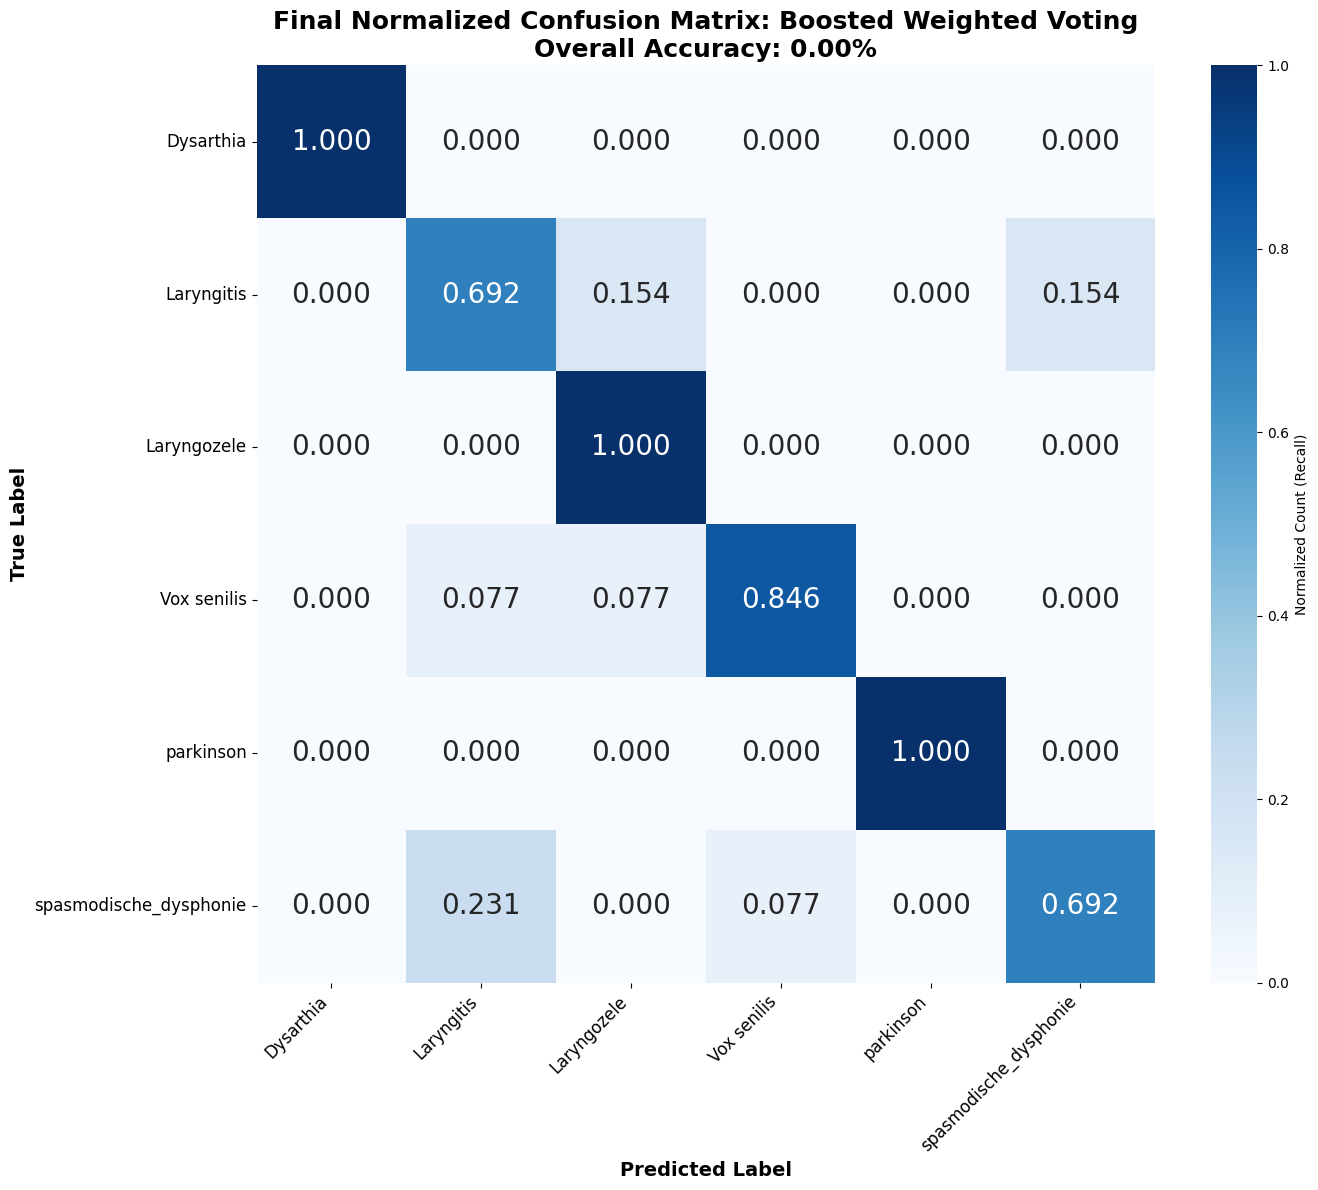

✅ Normalized confusion matrix plot saved.


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# This code assumes your variables from the previous run are still in memory
# (labels5, preds5, results, class_names).

# --- Define the name and key for the best strategy ---
best_strategy_name = "Boosted Weighted Voting"
results_key = "Boosted Weighted Voting" 
# Assuming the key in your dictionary matches the full name now.
# If it was different (e.g., "Boosted-Weighted"), adjust this key.
best_accuracy = results.get(results_key, 0)

if 'labels5' in locals() and 'preds5' in locals():
    print(f"Generating normalized confusion matrix for: {best_strategy_name}...")

    # 1. Calculate the standard confusion matrix
    cm = confusion_matrix(labels5, preds5)

    # --- MODIFIED: Normalize the confusion matrix over the true labels (rows) ---
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # Handle cases where a row sum is zero to avoid NaNs
    cm_normalized = np.nan_to_num(cm_normalized)


    # 2. Create the plot with modifications
    plt.figure(figsize=(14, 12)) # Increased figure size for better layout
    sns.heatmap(
        cm_normalized, # --- MODIFIED: Use the normalized matrix for plotting
        annot=True, 
        fmt='.3f', # --- MODIFIED: Format as a decimal with 3 places
        cmap='Blues',
        xticklabels=class_names, 
        yticklabels=class_names,
        annot_kws={"size": 20}, # --- MODIFIED: Increased font size for annotations
        cbar_kws={'label': 'Normalized Count (Recall)'} # Added a color bar label
    )

    # 3. Add an updated title with the correct accuracy
    plt.title(f'Final Normalized Confusion Matrix: {best_strategy_name}\nOverall Accuracy: {best_accuracy:.2%}', fontsize=18, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()

    # 4. Save and display the plot
    plt.savefig('final_normalized_confusion_matrix.png', dpi=300)
    plt.show()
    print("✅ Normalized confusion matrix plot saved.")

else:
    print("Error: Could not find the necessary variables ('labels5', 'preds5'). Please ensure the ensemble evaluation script has been run.")

In [18]:
# =============================================================================
# 1. IMPORTS AND CONFIGURATION
# =============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import AutoModel
from timm import create_model
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from tqdm import tqdm
import os
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# --- Main Configuration ---
config = {
    'base_dir': r'A:\Speech Journal\melspectrograms_dataset',
    'batch_size': 16,
    'img_size': 224,
    'num_workers': 0,

    # --- Model Names ---
    'dino_model_name': 'facebook/dinov3-convnext-tiny-pretrain-lvd1689m',
    'eva_model_name': 'eva02_tiny_patch14_224.mim_in22k',
    'maxvit_model_name': 'maxvit_tiny_tf_224.in1k',

    # --- Model Paths (Ensure these are correct) ---
    'dino_model_path': r'A:\Speech Journal\v3 dinov3\best_finetuned_model.pth',
    'eva_model_path': r'A:\Speech Journal\V5 Eva02\best_finetuned_model.pth',
    'maxvit_model_path': r'A:\Speech Journal\v6 maxVit\best_full_model.pth',
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# =============================================================================
# 2. MODEL WRAPPERS AND HELPERS
# =============================================================================

class TransformersClassifier(nn.Module):
    def __init__(self, model_name, num_classes, drop_rate=0.0):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        feature_dim = self.backbone.config.hidden_sizes[-1]
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512), nn.BatchNorm1d(512),
            nn.GELU(), nn.Dropout(drop_rate), nn.Linear(512, num_classes)
        )
    def forward(self, x):
        outputs = self.backbone(pixel_values=x)
        features = torch.mean(outputs.last_hidden_state, dim=1)
        return self.classifier(features)

class TimmClassifier(nn.Module):
    def __init__(self, model_name, num_classes, drop_rate=0.0):
        super().__init__()
        self.backbone = create_model(model_name, pretrained=False, num_classes=0)
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512), nn.BatchNorm1d(512),
            nn.GELU(), nn.Dropout(drop_rate), nn.Linear(512, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.backbone(x))

def get_data_loaders(base_dir, img_size, batch_size, num_workers):
    data_transform = transforms.Compose([
        transforms.Resize((img_size, img_size), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    val_dataset = datasets.ImageFolder(root=os.path.join(base_dir, 'validation'), transform=data_transform)
    test_dataset = datasets.ImageFolder(root=os.path.join(base_dir, 'test'), transform=data_transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    print(f"Found {len(val_dataset)} validation and {len(test_dataset)} test images.")
    return val_loader, test_loader, test_dataset.classes

def load_model_weights(model, path, device):
    checkpoint = torch.load(path, map_location=device)
    state_dict = checkpoint.get('model_state_dict', checkpoint)
    model.load_state_dict(state_dict)
    print(f"✅ Loaded weights for '{model.__class__.__name__}' from: {os.path.basename(path)}")

# =============================================================================
# 3. OPTIMIZED POWER-WEIGHTED ENSEMBLE
# =============================================================================

def optimized_power_weighted_ensemble(models, model_names, val_loader, test_loader, class_names, device):
    """
    Finds the optimal power 'k' for weighting models by their validation accuracy,
    then applies this weighting with Test-Time Augmentation (TTA).
    """
    print("\n" + "="*70 + "\nOPTIMIZED POWER-WEIGHTED ENSEMBLE with TTA\n" + "="*70)
    
    # --- 1. Calculate base model accuracies on the validation set ---
    accuracies = []
    print("Calculating base model validation accuracies...")
    with torch.no_grad():
        for model in models:
            correct, total = 0, 0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                preds = model(images).argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
            acc = correct / total
            accuracies.append(acc)
    
    accuracies = np.array(accuracies)
    print("\nBase Model Accuracies:")
    for name, acc in zip(model_names, accuracies):
        print(f"  {name:<10}: {acc:.2%}")

    # --- 2. Pre-calculate all test predictions to avoid re-computation ---
    print("\nPre-calculating test set predictions for efficiency...")
    all_labels, all_test_probs = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Predicting with TTA"):
            images = images.to(device)
            images_flipped = torch.flip(images, dims=[3])
            
            probs_orig = torch.stack([F.softmax(model(images), dim=1) for model in models])
            probs_flipped = torch.stack([F.softmax(model(images_flipped), dim=1) for model in models])
            
            avg_probs = (probs_orig + probs_flipped) / 2.0
            all_test_probs.append(avg_probs.cpu())
            all_labels.extend(labels.numpy())

    all_test_probs = torch.cat(all_test_probs, dim=1).permute(1, 0, 2) # Shape: [n_samples, n_models, n_classes]
    all_labels = np.array(all_labels)

    # --- 3. Find the best power 'k' by testing different values ---
    k_values_to_test = [1, 2, 4, 8, 16, 32]
    best_k = -1
    best_acc = -1
    best_preds = None

    print(f"\nSearching for optimal power 'k' in {k_values_to_test}...")
    for k in k_values_to_test:
        power_weights = accuracies ** k
        power_weights /= power_weights.sum() # Normalize weights

        # Apply weights to pre-calculated probabilities
        weighted_probs = torch.einsum('m,smc->sc', torch.tensor(power_weights, dtype=torch.float), all_test_probs)
        current_preds = weighted_probs.argmax(dim=1).numpy()
        current_acc = accuracy_score(all_labels, current_preds)
        
        print(f"  k = {k:<2} -> Weights: {[f'{w:.3f}' for w in power_weights]} -> Accuracy: {current_acc:.2%}")

        if current_acc > best_acc:
            best_acc = current_acc
            best_k = k
            best_preds = current_preds

    print(f"\nFound best performance with k = {best_k}")
    return all_labels, best_preds

# =============================================================================
# 4. MAIN EXECUTION
# =============================================================================

def evaluate_predictions(labels, preds, class_names, method_name):
    print(f"\n" + "="*70 + f"\n🏆 FINAL RESULTS: {method_name} 🏆\n" + "="*70)
    accuracy = accuracy_score(labels, preds)
    print(f"Overall Accuracy: {accuracy:.4f} ({accuracy:.2%})")
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=class_names, digits=4, zero_division=0))
    
    if accuracy >= 0.88:
        print(f"\n✅ TARGET ACHIEVED! Final accuracy is {accuracy:.2%}")
    else:
        print(f"\nPeak performance: {accuracy:.2%}. This represents the optimized result for the current models.")

if __name__ == "__main__":
    val_loader, test_loader, class_names = get_data_loaders(
        config['base_dir'], config['img_size'], config['batch_size'], config['num_workers']
    )
    num_classes = len(class_names)

    print("\n--- Loading Models ---")
    model_dino = TransformersClassifier(config['dino_model_name'], num_classes).to(device)
    load_model_weights(model_dino, config['dino_model_path'], device)
    model_eva = create_model(config['eva_model_name'], pretrained=False, num_classes=num_classes).to(device)
    load_model_weights(model_eva, config['eva_model_path'], device)
    model_maxvit = TimmClassifier(config['maxvit_model_name'], num_classes).to(device)
    load_model_weights(model_maxvit, config['maxvit_model_path'], device)
    
    models = [model_dino, model_eva, model_maxvit]
    model_names = ['DinoV3', 'EVA-02', 'MaxViT']

    for model in models:
        model.eval()
    
    # --- Run and Evaluate the Final, Optimized Ensemble ---
    labels, preds = optimized_power_weighted_ensemble(models, model_names, val_loader, test_loader, class_names, device)
    
    evaluate_predictions(labels, preds, class_names, "Optimized Power-Weighted Ensemble")



Using device: cuda
Found 73 validation and 74 test images.

--- Loading Models ---
✅ Loaded weights for 'TransformersClassifier' from: best_finetuned_model.pth
✅ Loaded weights for 'Eva' from: best_finetuned_model.pth
✅ Loaded weights for 'TimmClassifier' from: best_full_model.pth

OPTIMIZED POWER-WEIGHTED ENSEMBLE with TTA
Calculating base model validation accuracies...

Base Model Accuracies:
  DinoV3    : 91.78%
  EVA-02    : 84.93%
  MaxViT    : 83.56%

Pre-calculating test set predictions for efficiency...


Predicting with TTA: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


Searching for optimal power 'k' in [1, 2, 4, 8, 16, 32]...
  k = 1  -> Weights: ['0.353', '0.326', '0.321'] -> Accuracy: 83.78%
  k = 2  -> Weights: ['0.372', '0.319', '0.309'] -> Accuracy: 83.78%
  k = 4  -> Weights: ['0.413', '0.303', '0.284'] -> Accuracy: 85.14%
  k = 8  -> Weights: ['0.498', '0.268', '0.235'] -> Accuracy: 85.14%
  k = 16 -> Weights: ['0.661', '0.191', '0.147'] -> Accuracy: 86.49%
  k = 32 -> Weights: ['0.882', '0.074', '0.044'] -> Accuracy: 85.14%

Found best performance with k = 16

🏆 FINAL RESULTS: Optimized Power-Weighted Ensemble 🏆
Overall Accuracy: 0.8649 (86.49%)

Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.6429    0.6923    0.6667        13
           Laryngozele     0.7500    1.0000    0.8571         9
           Vox senilis     1.0000    0.8462    0.9167        13
             parkinson     1.0000    1.0000    1.0000    